# Preliminary Settings and Data Initialization

Importing necessary libraries and downloading the data.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.io import gfile
import tensorflow_io as tfio
from tensorflow.python.ops import gen_audio_ops as audio_ops
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [16]:
SPEECH_DATA='speech_data'
!tar -xzf "data_speech_commands_v0.02.tar.gz" -C speech_data

In [3]:
# The audio is all sampled at 16KHz and should all be 1 second in length - so 1 second is 16000 samples
EXPECTED_SAMPLES=16000
# Noise floor to detect if any audio is present
NOISE_FLOOR=0.1
# How many samples should be abover the noise floor?
MINIMUM_VOICE_LENGTH= EXPECTED_SAMPLES/4

TRAIN_SIZE=0.8
VALIDATION_SIZE=0.1
TEST_SIZE=0.1

SPEECH_DATA='speech_data'

After extracting the files, we can see the following folders which we will use to access the data (basically our list of words)

In [4]:
words = [
    'backward',
    'bed',
    'bird',
    'cat',
    'dog',
    'down',
    'eight',
    'five',
    'follow',
    'forward',
    'four',
    'go',
    'happy',
    'house',
    'learn',
    'left',
    'marvin',
    'nine',
    'no',
    'off',
    'on',
    'one',
    'right',
    'seven',
    'sheila',
    'six',
    'stop',
    'three',
    'tree',
    'two',
    'up',
    'visual',
    'wow',
    'yes',
    'zero',
    '_background',
]

We use the following funcitons in order to gather information from audio files.

In [5]:
def get_files(word):
    return gfile.glob(SPEECH_DATA+'/'+word+'/*.wav')

def get_normalized_voice(input_audio):
    audio= input_audio-np.mean(input_audio)
    audio/= np.max(np.abs(audio))
    return audio

def get_voice_position(audio, noise_floor):
    return (tfio.audio.trim(get_normalized_voice(audio), axis=0, epsilon= noise_floor))

def is_enough_voice_present(audio, noise_floor, required_length):
    # Getting the length of voice using end and start points
    start, end= get_voice_position(audio, noise_floor)
    length= (end-start).numpy()
    return (length>=required_length)

def is_correct_length(audio, expected_length):
    return ((audio.shape[0]==expected_length).numpy())


def is_file_valid(file_name):
    audio_tensor= tfio.audio.AudioIOTensor(file_name)
    
    # Audio file having the correct length
    if not is_correct_length(audio_tensor, EXPECTED_SAMPLES):
        return False
    
    # Scaling audio into a float between -1 and 1 (Normalizing)
    audio= tf.cast(audio_tensor[:], tf.float32)
    audio= get_normalized_voice(audio)
    
    # Voice being present
    if not is_enough_voice_present(audio, NOISE_FLOOR, MINIMUM_VOICE_LENGTH):
        return False
    
    return True


# Generating Spectograms

In [6]:
def get_spectrogram(audio):
    audio= get_normalized_voice(audio)
    
    spectrogram = audio_ops.audio_spectrogram(audio, window_size=320, stride=160, magnitude_squared=True).numpy()
    
    # Reducing the number of frequency bins
    spectrogram = tf.nn.pool(
        input=tf.expand_dims(spectrogram, -1),
        window_shape=[1, 6],
        strides=[1, 6],
        pooling_type='AVG',
        padding='SAME')
    
    spectrogram= tf.squeeze(spectrogram, axis=0)
    spectrogram= np.log10(spectrogram+1e-6)

    return spectrogram

In [7]:
def get_background_noise():
    background_volume= np.random.uniform(0, 0.1)
    
    background_file= np.random.choice(get_files('_background_noise_'))
    background_tensor= tfio.audio.AudioIOTensor(background_file)
    
    start= np.random.randint(0, len(background_tensor)-16000)
    background_audio= tf.cast(background_tensor[start:start+16000], tf.float32)
    background_audio= get_normalized_voice(background_audio)
    
    return (background_volume*background_audio)


def process_audio_for_spectogram(file_path):
    audio_tensor= tfio.audio.AudioIOTensor(file_path)
    audio= tf.cast(audio_tensor[:], tf.float32)
    audio= get_normalized_voice(audio)
    
    # Random Reposition
    voice_start, voice_end= get_voice_position(audio, NOISE_FLOOR)
    end_gap= len(audio)-voice_end
    random_offset = np.random.uniform(0, voice_start+end_gap)
    audio = np.roll(audio,-random_offset+end_gap)
    
    audio+= get_background_noise()

    return get_spectrogram(audio)

We need to use compatible versions.

In [8]:
print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow I/O version: {tfio.__version__}")

TensorFlow version: 2.10.0
TensorFlow I/O version: 0.27.0


We get the audio files for each word, add some background noise to them and create their spectogram. We add the spectograms to our train, validate and test dataset (In order to balance out our dataset, we add more instances of our wake-up word to the dataset.).

In [9]:
def get_files_for_word(files, label, repeat):
    files= tf.repeat(files, repeat).numpy()
    return [(process_audio_for_spectogram(file_name), label) for file_name in tqdm(files, desc=f"{word} ({label})", leave=False)]


def process_word(word, repeat=1):
    
    label= words.index(word)
    files= [file_name for file_name in tqdm(get_files(word), desc="Checking for word", leave=False) if is_file_valid(file_name)]
    np.random.shuffle(files)
    
    train_size= int(len(files)*TRAIN_SIZE)
    validation_size= int(len(files)*VALIDATION_SIZE)
    test_size= int(len(files)*TEST_SIZE)
    
    # Get samples
    train.extend(get_files_for_word(files[:train_size], label, repeat=repeat))
    validate.extend(get_files_for_word(files[train_size:train_size+validation_size], label, repeat=repeat))
    test.extend(get_files_for_word(files[train_size+validation_size:], label, repeat=repeat))

train= []
validate= []
test= []

for word in tqdm(words, desc="Processing words"):
    if '_' not in word:
        # Balancing data set by adding more of the wake up word
        
        process_word(word, repeat= (70 if word=='marvin' else 1))
    
print(len(train), len(test), len(validate))

Processing words:   0%|          | 0/36 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/1664 [00:00<?, ?it/s]

backward (0):   0%|          | 0/1225 [00:00<?, ?it/s]

backward (0):   0%|          | 0/153 [00:00<?, ?it/s]

backward (0):   0%|          | 0/154 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/2014 [00:00<?, ?it/s]

bed (1):   0%|          | 0/998 [00:00<?, ?it/s]

bed (1):   0%|          | 0/124 [00:00<?, ?it/s]

bed (1):   0%|          | 0/126 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/2064 [00:00<?, ?it/s]

bird (2):   0%|          | 0/1293 [00:00<?, ?it/s]

bird (2):   0%|          | 0/161 [00:00<?, ?it/s]

bird (2):   0%|          | 0/163 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/2031 [00:00<?, ?it/s]

cat (3):   0%|          | 0/921 [00:00<?, ?it/s]

cat (3):   0%|          | 0/115 [00:00<?, ?it/s]

cat (3):   0%|          | 0/116 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/2128 [00:00<?, ?it/s]

dog (4):   0%|          | 0/1306 [00:00<?, ?it/s]

dog (4):   0%|          | 0/163 [00:00<?, ?it/s]

dog (4):   0%|          | 0/164 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3917 [00:00<?, ?it/s]

down (5):   0%|          | 0/2623 [00:00<?, ?it/s]

down (5):   0%|          | 0/327 [00:00<?, ?it/s]

down (5):   0%|          | 0/329 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3787 [00:00<?, ?it/s]

eight (6):   0%|          | 0/1858 [00:00<?, ?it/s]

eight (6):   0%|          | 0/232 [00:00<?, ?it/s]

eight (6):   0%|          | 0/233 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/4052 [00:00<?, ?it/s]

five (7):   0%|          | 0/2376 [00:00<?, ?it/s]

five (7):   0%|          | 0/297 [00:00<?, ?it/s]

five (7):   0%|          | 0/297 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/1579 [00:00<?, ?it/s]

follow (8):   0%|          | 0/1063 [00:00<?, ?it/s]

follow (8):   0%|          | 0/132 [00:00<?, ?it/s]

follow (8):   0%|          | 0/134 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/1557 [00:00<?, ?it/s]

forward (9):   0%|          | 0/1113 [00:00<?, ?it/s]

forward (9):   0%|          | 0/139 [00:00<?, ?it/s]

forward (9):   0%|          | 0/140 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3728 [00:00<?, ?it/s]

four (10):   0%|          | 0/2250 [00:00<?, ?it/s]

four (10):   0%|          | 0/281 [00:00<?, ?it/s]

four (10):   0%|          | 0/282 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3880 [00:00<?, ?it/s]

go (11):   0%|          | 0/2157 [00:00<?, ?it/s]

go (11):   0%|          | 0/269 [00:00<?, ?it/s]

go (11):   0%|          | 0/271 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/2054 [00:00<?, ?it/s]

happy (12):   0%|          | 0/1285 [00:00<?, ?it/s]

happy (12):   0%|          | 0/160 [00:00<?, ?it/s]

happy (12):   0%|          | 0/162 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/2113 [00:00<?, ?it/s]

house (13):   0%|          | 0/1132 [00:00<?, ?it/s]

house (13):   0%|          | 0/141 [00:00<?, ?it/s]

house (13):   0%|          | 0/142 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/1575 [00:00<?, ?it/s]

learn (14):   0%|          | 0/1096 [00:00<?, ?it/s]

learn (14):   0%|          | 0/137 [00:00<?, ?it/s]

learn (14):   0%|          | 0/137 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3801 [00:00<?, ?it/s]

left (15):   0%|          | 0/1876 [00:00<?, ?it/s]

left (15):   0%|          | 0/234 [00:00<?, ?it/s]

left (15):   0%|          | 0/235 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/2100 [00:00<?, ?it/s]

marvin (16):   0%|          | 0/100660 [00:00<?, ?it/s]

marvin (16):   0%|          | 0/12530 [00:00<?, ?it/s]

marvin (16):   0%|          | 0/12670 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3934 [00:00<?, ?it/s]

nine (17):   0%|          | 0/2758 [00:00<?, ?it/s]

nine (17):   0%|          | 0/344 [00:00<?, ?it/s]

nine (17):   0%|          | 0/346 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3941 [00:00<?, ?it/s]

no (18):   0%|          | 0/2464 [00:00<?, ?it/s]

no (18):   0%|          | 0/308 [00:00<?, ?it/s]

no (18):   0%|          | 0/309 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3745 [00:00<?, ?it/s]

off (19):   0%|          | 0/1188 [00:00<?, ?it/s]

off (19):   0%|          | 0/148 [00:00<?, ?it/s]

off (19):   0%|          | 0/150 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3845 [00:00<?, ?it/s]

on (20):   0%|          | 0/2390 [00:00<?, ?it/s]

on (20):   0%|          | 0/298 [00:00<?, ?it/s]

on (20):   0%|          | 0/300 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3890 [00:00<?, ?it/s]

one (21):   0%|          | 0/2324 [00:00<?, ?it/s]

one (21):   0%|          | 0/290 [00:00<?, ?it/s]

one (21):   0%|          | 0/292 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3778 [00:00<?, ?it/s]

right (22):   0%|          | 0/2111 [00:00<?, ?it/s]

right (22):   0%|          | 0/263 [00:00<?, ?it/s]

right (22):   0%|          | 0/265 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3998 [00:00<?, ?it/s]

seven (23):   0%|          | 0/2753 [00:00<?, ?it/s]

seven (23):   0%|          | 0/344 [00:00<?, ?it/s]

seven (23):   0%|          | 0/345 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/2022 [00:00<?, ?it/s]

sheila (24):   0%|          | 0/1384 [00:00<?, ?it/s]

sheila (24):   0%|          | 0/173 [00:00<?, ?it/s]

sheila (24):   0%|          | 0/173 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3860 [00:00<?, ?it/s]

six (25):   0%|          | 0/2321 [00:00<?, ?it/s]

six (25):   0%|          | 0/290 [00:00<?, ?it/s]

six (25):   0%|          | 0/291 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3872 [00:00<?, ?it/s]

stop (26):   0%|          | 0/2001 [00:00<?, ?it/s]

stop (26):   0%|          | 0/250 [00:00<?, ?it/s]

stop (26):   0%|          | 0/251 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3727 [00:00<?, ?it/s]

three (27):   0%|          | 0/2276 [00:00<?, ?it/s]

three (27):   0%|          | 0/284 [00:00<?, ?it/s]

three (27):   0%|          | 0/286 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/1759 [00:00<?, ?it/s]

tree (28):   0%|          | 0/1118 [00:00<?, ?it/s]

tree (28):   0%|          | 0/139 [00:00<?, ?it/s]

tree (28):   0%|          | 0/141 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3880 [00:00<?, ?it/s]

two (29):   0%|          | 0/2164 [00:00<?, ?it/s]

two (29):   0%|          | 0/270 [00:00<?, ?it/s]

two (29):   0%|          | 0/271 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/3723 [00:00<?, ?it/s]

up (30):   0%|          | 0/790 [00:00<?, ?it/s]

up (30):   0%|          | 0/98 [00:00<?, ?it/s]

up (30):   0%|          | 0/100 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/1592 [00:00<?, ?it/s]

visual (31):   0%|          | 0/1149 [00:00<?, ?it/s]

visual (31):   0%|          | 0/143 [00:00<?, ?it/s]

visual (31):   0%|          | 0/145 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/2123 [00:00<?, ?it/s]

wow (32):   0%|          | 0/1356 [00:00<?, ?it/s]

wow (32):   0%|          | 0/169 [00:00<?, ?it/s]

wow (32):   0%|          | 0/170 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/4044 [00:00<?, ?it/s]

yes (33):   0%|          | 0/2364 [00:00<?, ?it/s]

yes (33):   0%|          | 0/295 [00:00<?, ?it/s]

yes (33):   0%|          | 0/297 [00:00<?, ?it/s]

Checking for word:   0%|          | 0/4052 [00:00<?, ?it/s]

zero (34):   0%|          | 0/2957 [00:00<?, ?it/s]

zero (34):   0%|          | 0/369 [00:00<?, ?it/s]

zero (34):   0%|          | 0/371 [00:00<?, ?it/s]

161100 20258 20070


Then, we generate some negative samples from our background noises. We create their spectograms and add them to our datasets.

In [11]:
def proecss_background_for_spectogram(file_name, label):
    audio_tensor= tfio.audio.AudioIOTensor(file_name)
    audio= tf.cast(audio_tensor[:], tf.float32)
    audio_length= len(audio)
    
    samples= []
    
    for start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 8000), desc=file_name, leave=False):
        spectrogram= get_spectrogram(audio[start:start+EXPECTED_SAMPLES])
        samples.append((spectrogram, label))

    
    for _ in tqdm(range(1000), desc="Simulated Words", leave=False):
        start= np.random.randint(0, audio_length-EXPECTED_SAMPLES)
        section= np.reshape(audio[start:start+EXPECTED_SAMPLES], (EXPECTED_SAMPLES))

        result= np.zeros((EXPECTED_SAMPLES))

        voice_length= np.random.randint(MINIMUM_VOICE_LENGTH/2, EXPECTED_SAMPLES)
        voice_start= np.random.randint(0, EXPECTED_SAMPLES-voice_length)
        hamming= np.hamming(voice_length)

        result[voice_start:voice_start+voice_length]= hamming*section[voice_start:voice_start+voice_length]

        samples.append((get_spectrogram(np.reshape(section, (16000, 1))), label))
        
    np.random.shuffle(samples)
    
    train_size= int(len(samples)*TRAIN_SIZE)
    validation_size= int(len(samples)*VALIDATION_SIZE)
    test_size= int(len(samples)*TEST_SIZE)
    
    train.extend(samples[:train_size])
    validate.extend(samples[train_size:train_size+validation_size])
    test.extend(samples[train_size+validation_size:])

        
for file_name in tqdm(get_files('_background_noise_'), desc="Processing Background Noise"):
    proecss_background_for_spectogram(file_name, words.index("_background"))
    
print(len(train), len(test), len(validate))

Processing Background Noise:   0%|          | 0/6 [00:00<?, ?it/s]

speech_data\_background_noise_\doing_the_dishes.wav:   0%|          | 0/189 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech_data\_background_noise_\dude_miaowing.wav:   0%|          | 0/122 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech_data\_background_noise_\exercise_bike.wav:   0%|          | 0/121 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech_data\_background_noise_\pink_noise.wav:   0%|          | 0/118 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech_data\_background_noise_\running_tap.wav:   0%|          | 0/121 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

speech_data\_background_noise_\white_noise.wav:   0%|          | 0/118 [00:00<?, ?it/s]

Simulated Words:   0%|          | 0/1000 [00:00<?, ?it/s]

166528 20943 20746


In [12]:
def process_problem_noies_for_spectogram(file_name, label):
    audio_tensor= tfio.audio.AudioIOTensor(file_name)
    audio= tf.cast(audio_tensor[:], tf.float32)
    audio_length= len(audio)
    
    samples = []
    for start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 400), desc=file_name, leave=False):
        spectrogram= get_spectrogram(audio[start:start+EXPECTED_SAMPLES])
        samples.append((spectrogram, label))
        
    np.random.shuffle(samples)
    
    train_size= int(len(samples)*TRAIN_SIZE)
    validation_size= int(len(samples)*VALIDATION_SIZE)
    test_size= int(len(samples)*TEST_SIZE)
    
    train.extend(samples[:train_size])
    validate.extend(samples[train_size:train_size+validation_size])
    test.extend(samples[train_size+validation_size:])


for file_name in tqdm(get_files("_problem_noise_"), desc="Processing problem noise"):
    process_problem_noies_for_spectogram(file_name, words.index("_background"))
    
    
print(len(train), len(test), len(validate))

Processing problem noise: 0it [00:00, ?it/s]

166528 20943 20746


In [13]:
def process_wakeup_similar_sounds_for_spectogram(file_name, label):
    audio_tensor= tfio.audio.AudioIOTensor(file_name)
    audio= tf.cast(audio_tensor[:], tf.float32)
    audio_length= len(audio)
    
    samples= []
    for start in tqdm(range(0, audio_length-EXPECTED_SAMPLES, 4000), desc=file_name, leave=False):
        
        section= get_normalized_voice(audio[start:start+EXPECTED_SAMPLES])
        section+= get_background_noise()
        
        spectrogram= get_spectrogram(section)
        samples.append((spectrogram, label))
        
    np.random.shuffle(samples)
    
    train_size= int(len(samples)*TRAIN_SIZE)
    validation_size= int(len(samples)*VALIDATION_SIZE)
    test_size= int(len(samples)*TEST_SIZE)
    
    train.extend(samples[:train_size])
    validate.extend(samples[train_size:train_size+validation_size])
    test.extend(samples[train_size+validation_size:])


for file_name in tqdm(get_files("_mar_sounds_"), desc="Processing problem noise"):
    process_wakeup_similar_sounds_for_spectogram(file_name, words.index("_background"))

Processing problem noise: 0it [00:00, ?it/s]

In [14]:
print(len(train), len(test), len(validate))

166528 20943 20746


In [15]:
np.random.shuffle(train)
x_train, y_train = zip(*train)
x_validate, y_validate = zip(*validate)
x_test, y_test = zip(*test)

In [16]:

np.savez_compressed("training_spectrogram.npz", X=x_train, Y=y_train)
print("Saved training data")

np.savez_compressed("validation_spectrogram.npz", X=x_validate, Y=y_validate)
print("Saved validation data")

np.savez_compressed("test_spectrogram.npz", X=x_test, Y=y_test)
print("Saved test data")

Saved training data
Saved validation data
Saved test data


In [17]:
# get the width and height of the spectrogram "image"
IMG_WIDTH=x_train[0].shape[0]
IMG_HEIGHT=x_train[0].shape[1]

In [18]:
def plot_images(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(5, 5, figsize=(10, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.reshape(img, (imageWidth, imageHeight)))
        ax.axis("off")
    plt.tight_layout()
    plt.show()
    

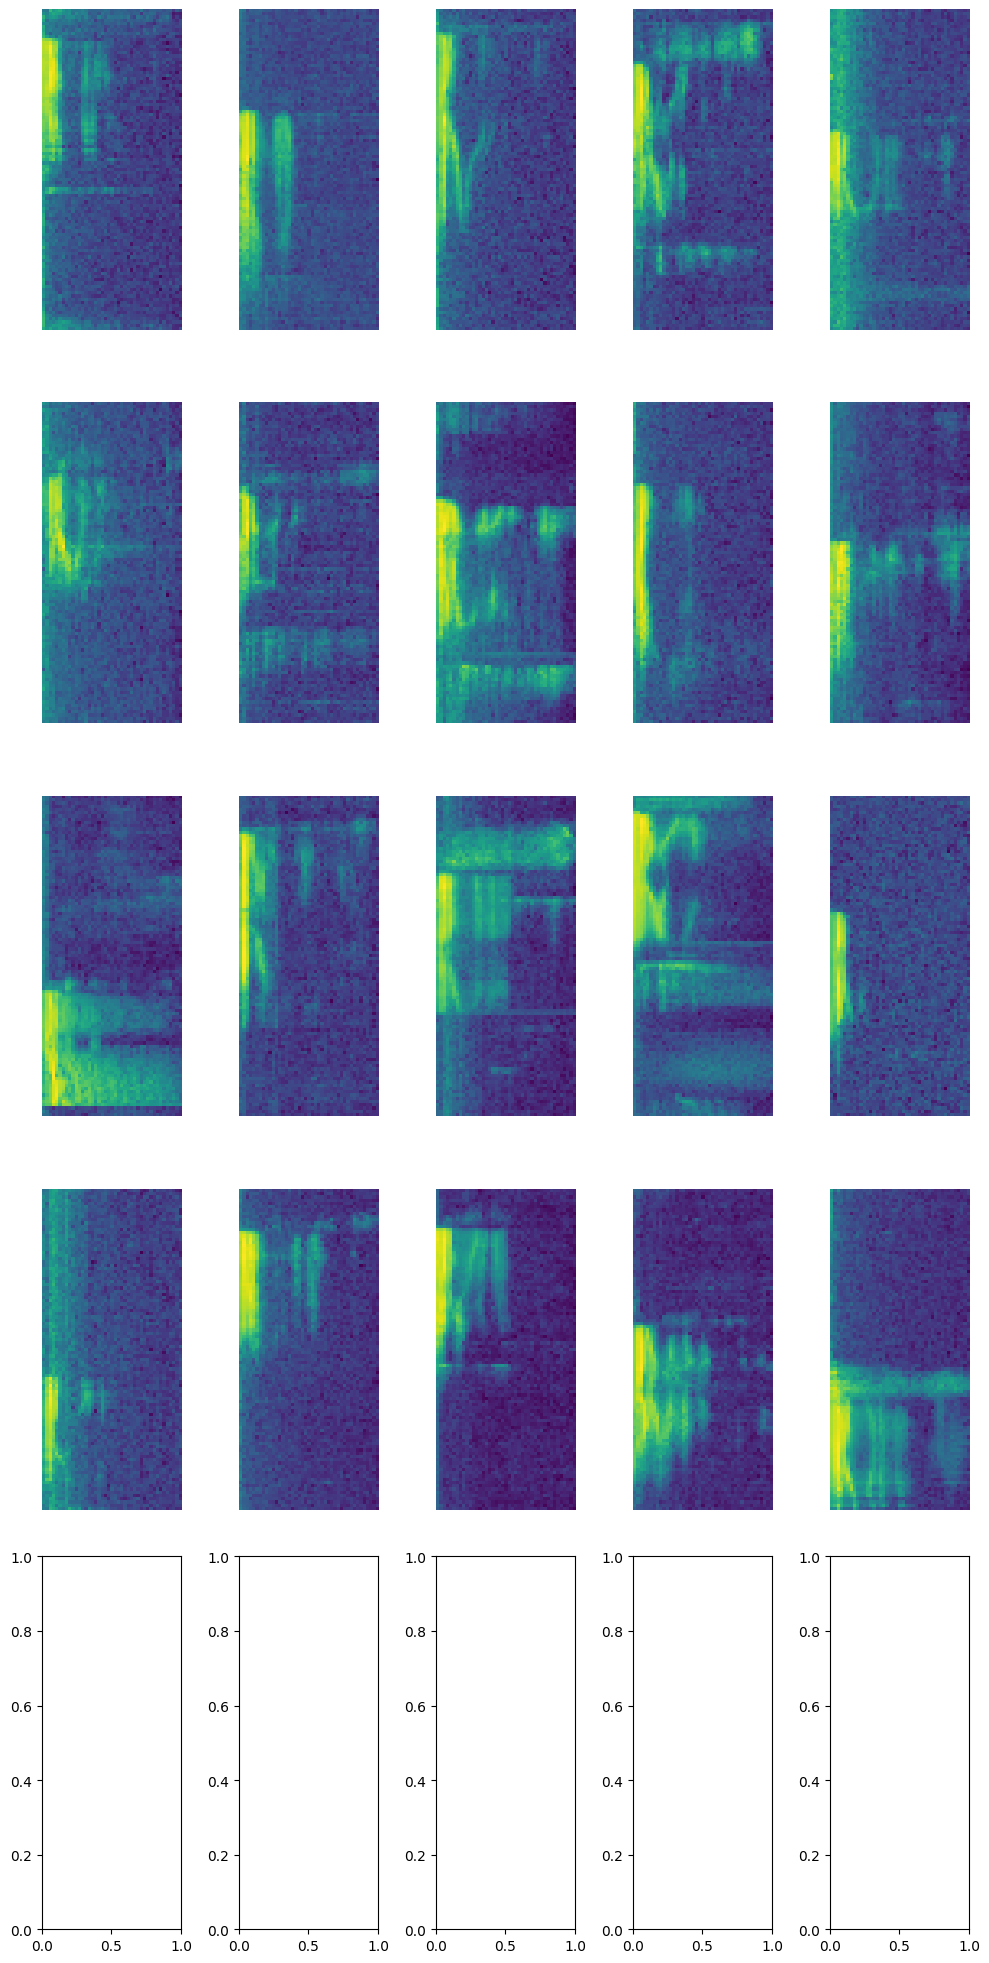

[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


In [19]:
word_index= words.index("forward")

X_word= np.array(x_train)[np.array(y_train)==word_index]
Y_word= np.array(y_train)[np.array(y_train)==word_index]
plot_images(X_word[:20], IMG_WIDTH, IMG_HEIGHT)
print(Y_word[:20])